<a href="https://colab.research.google.com/github/jonasgebele/Predicting-interactions-of-m6A-regulated-RNA-binding-proteins/blob/main/model/Predicting_interactions_of_m6A_regulated_RNA_binding_proteins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting interactions of m6A-regulated RNA-binding proteins


In [111]:
# Notes: (from the meeting)
# -Motifs are usually captured in the first layer
# -"high methylation" means a dataset with a more overlaps between both datasets, thus more methylation being included
# -maybe later; One-hot encoding based on methylation rate threshold and stricter methylation data, where the methylated A is exactly in the middle (didnt completely got what Giuliana meant with that)

In [112]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [113]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import models, layers

In [114]:
from google.colab import drive
import os
gdrive_path='/content/gdrive/MyDrive/Predicting_interactions_of_m6A-regulated_RNA-binding_proteins/data'

# This will mount  google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['KerasTuner', 'Preprocessing.ipynb', 'data.fasta', 'data_19k.fasta', 'data_smallest.fasta', 'processing_commands.gdoc']


In [115]:
base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

def load_fasta(fasta):
    with open(fasta) as f:
        for line in f:
            if line[0] != '>':
                raise ValueError(f'Expected FASTA header, got \'{line.strip()[:10]}\'')

            label = int(line.strip()[1])
            
            sequence = f.readline().strip()
            # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
            sequence_int = [base2int.get(base, 9999) for base in sequence]
            # One-hot encode sequence integers, i.e. 0 (A) as [1,0,0,0], 1 (C) as [0,1,0,0], etc.
            sequence_onehot = tf.one_hot(sequence_int, depth=4)

            m6A_binding = f.readline().strip()
            m6A_binding_int = tf.constant([int(x) for x in m6A_binding])
            m6A_binding_int = tf.reshape(m6A_binding_int, (1, 200))
 
            m6A_binding_int = tf.cast( m6A_binding_int, tf.float32)

            numpy_onehot = sequence_onehot.numpy() 
            numpy_m6A = m6A_binding_int.numpy()

            numpy_sequence_m6A = np.concatenate((numpy_onehot, numpy_m6A.T), axis=1)
            
            sequence_m6A = tf.convert_to_tensor(numpy_sequence_m6A, np.float32)

            yield sequence_m6A, label

In [116]:
dataset = tf.data.Dataset.from_generator(lambda: load_fasta('./data_19k.fasta'), 
                                         output_signature=(tf.TensorSpec(shape=(200,5), dtype=tf.float32), 
                                                           tf.TensorSpec(shape=(), dtype=tf.float32)))
dataset = dataset.cache()

In [117]:
dataset.element_spec

(TensorSpec(shape=(200, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [135]:
i = 10
for element in dataset:
  print(element)
  i += 1
  if i > 1:
    break

(<tf.Tensor: shape=(200, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1

In [119]:
def construct_model():
    model = models.Sequential(name='ML4RG_SS22_Model')

    # Define input shape, i.e. 200x5
    model.add(layers.Input(shape=(200, 5)))

    # CNN Block 1
    model.add(layers.Convolution1D(64, kernel_size=9, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # CNN Block 2
    model.add(layers.Convolution1D(64, kernel_size=4, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # CNN Block 3
    model.add(layers.Convolution1D(64, kernel_size=4, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # Flatten output of last Conv1D block into a 1D vector
    model.add(layers.Flatten())

    # Feed flattened Conv1D output into MLP layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))

    # Add logistic classifier on top
    model.add(layers.Dense(1, activation='sigmoid'))

    # Train with Adam optimizer and binary cross-entropy loss
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

In [120]:
model = construct_model()
model.summary()

Model: "ML4RG_SS21_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 192, 64)           2944      
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 96, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 64)            16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 93, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 46, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 43, 64)       

In [121]:
dataset = dataset.shuffle(len(list(dataset)))

In [122]:
n_samples = [i for i, _ in enumerate(dataset, start=1)][-1]

dataset_train = dataset.take(int(n_samples * 0.70))
dataset_val = dataset.skip(int(n_samples * 0.70)).take(int(n_samples * 0.15))
dataset_test = dataset.skip(int(n_samples * 0.70) + int(n_samples * 0.15))

In [123]:
len(list(dataset_train))

13580

In [124]:
dataset_train = dataset_train.shuffle(13_580).batch(128)
dataset_val = dataset_val.batch(128)

In [125]:
history = model.fit(dataset_train, validation_data=dataset_val, epochs = 1500)

Epoch 1/1500
107/107 [==============================] - 2s 9ms/step - loss: 0.6597 - accuracy: 0.6497 - val_loss: 0.6579 - val_accuracy: 0.6773
Epoch 2/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6356 - accuracy: 0.6702 - val_loss: 0.6535 - val_accuracy: 0.6656
Epoch 3/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6378 - accuracy: 0.6683 - val_loss: 0.6358 - val_accuracy: 0.6835
Epoch 4/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6395 - accuracy: 0.6706 - val_loss: 0.6501 - val_accuracy: 0.6574
Epoch 5/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6324 - accuracy: 0.6741 - val_loss: 0.6533 - val_accuracy: 0.6722
Epoch 6/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6273 - accuracy: 0.6740 - val_loss: 0.6524 - val_accuracy: 0.6722
Epoch 7/1500
107/107 [==============================] - 1s 7ms/step - loss: 0.6367 - accuracy: 0.6643 - val_loss: 0.6434 - val_accuracy:

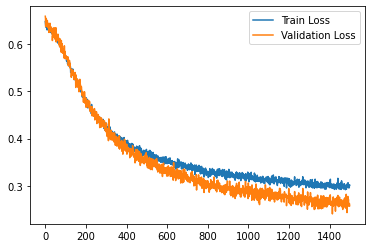

In [126]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['loss'], label = "Train Loss")
plt.plot(history.epoch, history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()

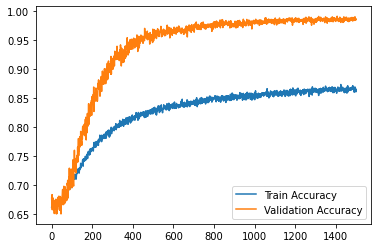

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['accuracy'], label = "Train Accuracy")
plt.plot(history.epoch, history.history['val_accuracy'], label = "Validation Accuracy")
plt.legend()
plt.show()

In [137]:
!pip install -q -U keras-tuner

In [128]:
from kerastuner.tuners import RandomSearch

In [138]:
def construct_hypermodel(hp):
    model = models.Sequential(name='ML4RG_SS21_Model')

    # Hyperparameters
    conv1d_1_kernel_num = hp.Int(name='conv1d_1_kernel_num' , min_value=32, max_value=128, step=32)
    conv1d_1_kernel_size = hp.Int(name='conv1d_1_kernel_size', min_value=4, max_value=12, step=4)
    optimizer = hp.Choice(name='optimizer', values=['Adam', 'RMSprop', 'SGD'])


    # Define input shape, i.e. 150x4
    model.add(layers.Input(shape=(200, 5)))

    # CNN Block 1
    model.add(layers.Convolution1D(conv1d_1_kernel_num, kernel_size=conv1d_1_kernel_size, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # CNN Block 2
    model.add(layers.Convolution1D(64, kernel_size=4, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # CNN Block 3
    model.add(layers.Convolution1D(64, kernel_size=4, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))
    model.add(layers.MaxPool1D(2))

    # Flatten output of last Conv1D block into a 1D vector
    model.add(layers.Flatten())

    # Feed flattened Conv1D output into MLP layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5, seed = 123))

    # Add logstic classifier on top
    model.add(layers.Dense(1, activation='sigmoid'))

    # Train with Adam optimizer and binary cross-entropy loss
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [142]:
tuner = RandomSearch(
    construct_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='KerasTuner',
    project_name='ML4R_SS22')

In [143]:
# Print the search space
tuner.search_space_summary()

Search space summary
Default search space size: 3
conv1d_1_kernel_num (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
conv1d_1_kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 12, 'step': 4, 'sampling': None}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop', 'SGD'], 'ordered': False}


In [144]:
tuner.search(dataset_train, epochs=5, validation_data=dataset_val)

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.6819587647914886

Best val_accuracy So Far: 0.6831614971160889
Total elapsed time: 00h 01m 55s
INFO:tensorflow:Oracle triggered exit


In [145]:
# Get the best model
model = tuner.get_best_models(num_models=1)

In [146]:
# Evaluating the best model
model[0].evaluate(dataset_test.batch(128))

23/23 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6650


[0.6627087593078613, 0.65395188331604]